In [128]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import time
from binarytree import *
from math import *
import statistics

from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import neighbors

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


# PART 1

"Tune the best k of a kNN classifier by cross-validation (plot the accuracies over the validation subset
w.r.t. k) from 4000 randomly drawn training examples (you will keep apart 1000 waves for the test
set)."

In [4]:
#We import the file
df = pd.read_csv('waveform.data', sep = ',', header=None)

 1 - Data divisions, 4000 training examples 1000 test

In [5]:
trainingSet = df.iloc[0:4000]
testSet =  df.iloc[4000:5000]

X_train = trainingSet.iloc[:,0:21]
y_train = trainingSet.iloc[:,21]

X_test = testSet.iloc[:,0:21]
y_test = testSet.iloc[:,21]

2 - We will divide the training data into 5 subsets and train the kNN classifier on each subset and evaluate its performance. The average of the scores will be calculated. To determine the best k, we will try different values of k and use cross-validation to assess their performance.

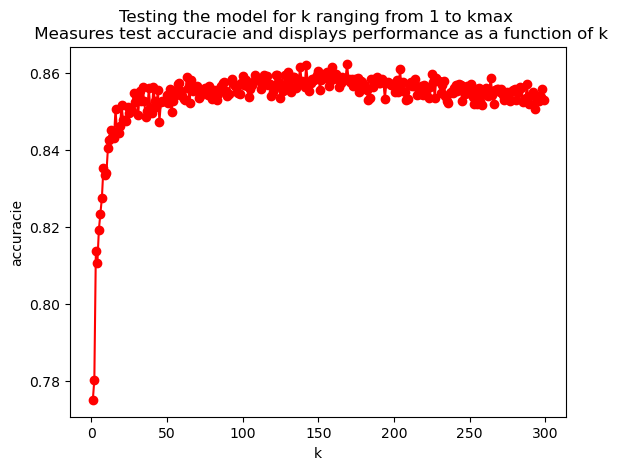

Best value of k: 169
Associated score: 0.85825


In [228]:
# Separation of training data into 5 subsets
kfold = KFold(n_splits=5, shuffle=True)


k_values = range(1, 300)

k_scores = []

for k in k_values:
  # Creating the kNN classifier
  knn = KNeighborsClassifier(n_neighbors=k)

  # List to store the scores of each iteration
  scores = []
 
  for train_index, test_index in kfold.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    knn.fit(X_train_fold, y_train_fold)

    score = knn.score(X_test_fold, y_test_fold)
    scores.append(score)

  mean_score = sum(scores) / len(scores)

  k_scores.append(mean_score)


# Find the k which has the best score (We start at k=1 hence the "+1")
best_k = k_scores.index(max(k_scores))+1

#We plot the accuracies as a function of k
fig = plt.figure()

plt.title("Testing the model for k ranging from 1 to kmax \n Measures test accuracie and displays performance as a function of k")
plt.xlabel('k')
plt.ylabel('accuracie')

plt.plot(k_values, k_scores, 'o-', color='red')

plt.show()

# Result display
print("Best value of k:", best_k)
print("Associated score:", k_scores[best_k])

# PART 2

"Reduce the complexity by running the Data Reduction algorithms studied in class on the training
data. Compare the accuracy (with a 1NN) on the 1000 test waves before and after reduction of the
training set."

Preliminary step : remove from S the outliers and the examples of the bayes error region

In [119]:
def miss(trainingSet, testSet, y_train, y_test):
    stable = False
    index = []
    
    knn = neighbors.KNeighborsClassifier(1)
    knn.fit(trainingSet, y_train)
    predicted = knn.predict(testSet)

    for i in range(len(testSet)) :
        if predicted[i] != y_test.iloc[i] :
            index.append(i)

    X = testSet.drop(index, axis=0).reset_index(drop = True)
    y = y_test.drop(index, axis=0).reset_index(drop = True)

    if len(index) == 0 :
        stable = True

    return X, y, stable


def reduction(X, y) :

    X1 = X.iloc[0:int(len(X)/2)].reset_index(drop = True)
    X2 = X.iloc[int(len(X)/2):len(X)].reset_index(drop = True)
 
    y1 = y.iloc[0:int(len(y)/2)].reset_index(drop = True)
    y2 = y.iloc[int(len(y)/2):len(y)].reset_index(drop = True)
    
    s_X1 = False
    s_X2 = False
    
    while s_X1==False and s_X2==False :
        X1, y1, s_X1 = miss(X2, X1, y2, y1)
        X2, y2, s_X2 = miss(X1, X2, y1, y2)
       
    #Returns the union of the two sets
    X = pd.concat([X1, X2], ignore_index=True, sort=False)
    y = pd.concat([y1, y2], ignore_index=True, sort=False)

    return X, y

Second step: remove the irrelevant examples

In [120]:
def correctly(trainingSet, test, y_train, y_test):

    knn = neighbors.KNeighborsClassifier(1)
    knn.fit(trainingSet, y_train)
    predicted = knn.predict(test)
    
    if predicted[0] != y_test :
        return False

    return True

def reduction_cnn(X, y) :

    s_storage = False
    poubelle = []
    X_storage = X.iloc[0:1]
    y_storage = y.iloc[0:1]

    while s_storage == False :
        s_storage = True
        for i in range(len(X)) :
            if correctly(X_storage, X.iloc[i:i+1], y_storage, y.iloc[i]) :
                poubelle.append(i)
            else :
                X_storage = pd.concat([X_storage, X.iloc[i:i+1]]).reset_index(drop = True)
                y_storage = pd.concat([y_storage, y.iloc[i:i+1]]).reset_index(drop = True)
                s_storage = False

        X = X.drop(poubelle, axis=0).reset_index(drop = True)
        y = y.drop(poubelle, axis=0).reset_index(drop = True)
        poubelle = []
            
    return X_storage, y_storage

Visualization of our cleaned data

In [121]:
#To draw our points in 2d
def graphic(X, y, string):

    plt.scatter(X[y == 0, 0], X[y == 0, 1], label="Class 0", color = 'r')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label="Class 1", color = 'g')
    plt.scatter(X[y == 2, 0], X[y == 2, 1], label="Class 2", color = 'b')
    plt.title(string)

    plt.show()

First step, it remains 3183 samples
Second step, it remains 498 samples


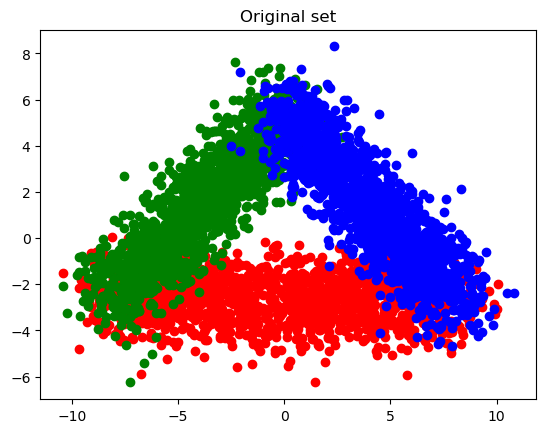

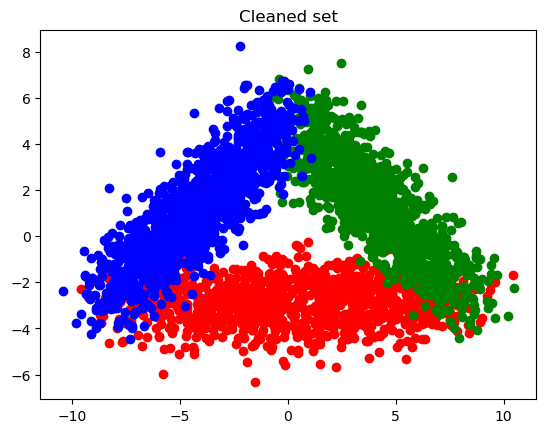

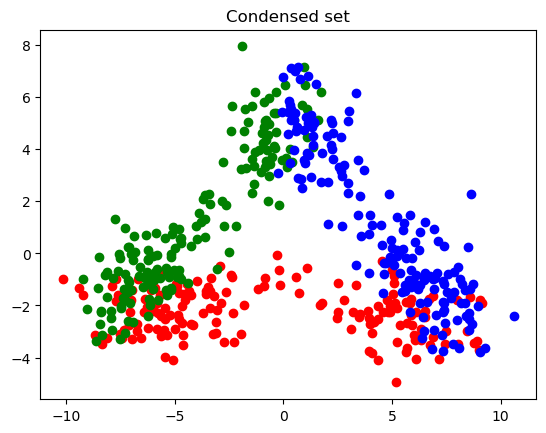

In [226]:
# Instantiate a PCA object for easy viewing
pca = PCA(n_components=2)
# Adjust and transform X to visualize in 2D space
X_vis = pca.fit_transform(X_train)

X_clean, y_clean = reduction(X_train, y_train)
print("First step, it remains", len(X_clean),"samples")
X_cnn, y_cnn = reduction_cnn(X_clean, y_clean)
print("Second step, it remains", len(X_cnn),"samples")

X_vis_clean = pca.fit_transform(X_clean)
X_vis_cnn = pca.fit_transform(X_cnn)

graphic(X_vis, y_train, 'Original set')
graphic(X_vis_clean, y_clean, 'Cleaned set')
graphic(X_vis_cnn, y_cnn, 'Condensed set')

Let's compare the accuracy in the original set and in the cleaned set

In [227]:
def knn_accuracy(trainingSet, testSet, y_train, y_test, k):
       
    knn = KNeighborsClassifier(k)
    knn.fit(trainingSet, y_train)

    y_pred = knn.predict(testSet)
    accuracy = accuracy_score(y_test, y_pred)*100

    return accuracy

a1 =  knn_accuracy(X_train, X_test, y_train, y_test, 1)
a2 =  knn_accuracy(X_clean, X_test, y_clean, y_test, 1)
a3 = knn_accuracy(X_cnn, X_test, y_cnn, y_test, 1)

print("1 step : precision 1NN reduction:", a1 , "%")
print("2 step : precision 1NN reduction:", a2 , "%")
print("precision 1NN after reduction:", a3, "%")

1 step : precision 1NN reduction: 76.3 %
2 step : precision 1NN reduction: 80.0 %
precision 1NN after reduction: 76.9 %


# PART 3

"Using the original dataset, compare (in terms of time) the two methods studied in class for
speeding-up the calculation of the 1NN with a brute force 1NN algorithm."

In [198]:
X = df.iloc[:,0:21]
y = df.iloc[:,21]

[2.0008087158203125, 4.999876022338867, 7.999897003173828]
[370.4226016998291, 284.9454879760742, 78.02844047546387]


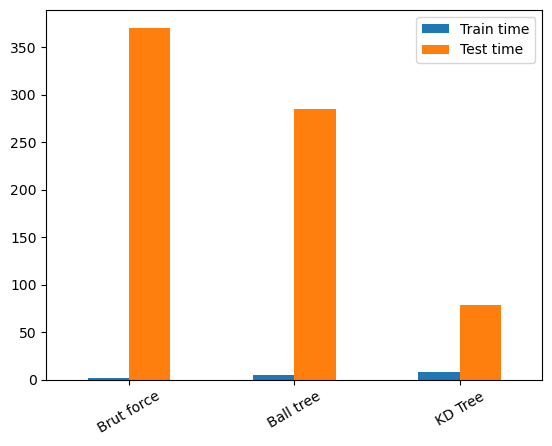

In [216]:
import time
from pandas import plotting

Train_time = []
Test_time = []

#Brut Force
knn = KNeighborsClassifier(n_neighbors=1, algorithm="brute")

start = time.time()
knn.fit(X, y)
Train_time.append((time.time() - start)*1000)

start = time.time()
knn.predict(X)
Test_time.append((time.time() - start)*1000)


#Ball Tree
knn = KNeighborsClassifier(n_neighbors=1, algorithm="ball_tree")

start = time.time()
knn.fit(X, y)
Train_time.append((time.time() - start)*1000)

start = time.time()
knn.predict(X)
Test_time.append((time.time() - start)*1000)

#KD Tree
knn = KNeighborsClassifier(n_neighbors=1, algorithm="kd_tree")

start = time.time()
knn.fit(X, y)
Train_time.append((time.time() - start)*1000)

start = time.time()
knn.predict(X)
Test_time.append((time.time() - start)*1000)

print(Train_time)
print(Test_time)

mydata = pd.DataFrame({"Train time":Train_time,"Test time":Test_time})

mydata.index = ["Brut force","Ball tree","KD Tree"]

mydata.plot(kind="bar",rot=30) 

plt.show()

Now let's code our 3 algorithms seen in class !

1 - Brute force algorithm

In [196]:
#Calculate the Euclidean distance between two data
def distanceEuclidienne(test, train):
        distance = 0
        for i,j in zip(test, train):
            distance += np.square(i - j)
        result = np.sqrt(distance)
        return result

#Gives the result of the vote between labels
def Vote(tabLabels) :
    numOf0 = tabLabels.count(0)
    numOf1 = tabLabels.count(1)
    numOf2 = tabLabels.count(2)
       
    if numOf0 > numOf1 and numOf0 > numOf2 : 
        return 0
    elif numOf1 > numOf0 and numOf1 > numOf2 : 
        return 1
    else : 
        return 2

def BrutForce(trainingSet, test, y, k):
    distances = []

    #Calculate distance between test data and each line of training data
    for i in range(len(trainingSet)): 
        distance = (distanceEuclidienne(test, trainingSet.iloc[i]),i)
        distances.append(distance)
        
    #lists of distances sorted in ascending order
    distances.sort()

    #We get the first k values
    k_proches = distances[:k]

    #We identify the labels of each value
    tabLabels = []
    for i in k_proches :
        distance,index = i
        tabLabels.append(y.iloc[index])
        
    #Returns the result of the vote
    return Vote(tabLabels)

2 - Method seen in class using distance comparisons

Matrix of distances between points (it's long !)

In [197]:
def matriceDistance(trainingSet):
    n = len(trainingSet)
    #initialization of the matrix to -1
    M = np.ones((n, n)).dot(-1)
    for i in range(n):
        for j in range(n):
            #We avoid calculating the same distance twice
            if j<i :
                M[i, j] = distanceEuclidienne(trainingSet.iloc[i],trainingSet.iloc[j])
            elif i==j :
                M[i, j] = 0
    return M

M = matriceDistance(X_train)

In [209]:
def Ball(M, trainingSet, test, y):

    index = 0

    L = []
    for i in range(len(trainingSet)):
        L.append(i)
    
    dmin = distanceEuclidienne(test, trainingSet.iloc[0]) 
    del L[0]
    
    while L :
        #d = distance entre X et Xn
        d = distanceEuclidienne(test, trainingSet.iloc[L[0]])
        dcenter = L[0]
        
        if d <= dmin :
            dmin = d
            index = L[0]
        
        del L[0]
        
        if d > dmin : 
            supp = 0 
            #On supprime les points dans le cercle d-dmin et en dehors du cercle  d+min
            for j in L : 
                    
                #dist = distance entre Xn et un point de la liste
                if M[dcenter,j]!=-1 :
                    dist = M[dcenter,j]
                else :
                    dist = M[j,dcenter]
                    
                if dist < d-dmin :
                    supp += 1
                    L.remove(j)
                elif dist > d+dmin :
                    supp += 1
                    L.remove(j)
    
    return y.iloc[index]

3 - Method seen in class, kd tree

In [210]:
#personalization of the node
class Noeud(Node):

    def __init__(self, _id, data, axe, idx):
            super().__init__(_id)
            self.data = data
            self.axe = axe
            self.tree = None

class KD_trees :

    #receives the training data
    def __init__(self, data):
        self.data = data
        self.tree = None

    ##################################################
    #                TREE CONSTRUCTION               #
    ##################################################

    def _cons(self, data, profondeur):
        
        if len(data)==0 :
           return None

        #dimension of a point
        k = len(data.columns)

        #we select an axis so that it passes through the valid values
        _axe = profondeur % k

        #We sort our data according to the axes
        _data = data.sort_values(by=[_axe])

        #The median is chosen to split our data
        mediane = len(data)//2

        #We create a node
        noeud =  Noeud(float(_data.iloc[mediane][_axe]), _data.iloc[mediane], _axe, mediane)

        #We build the sub-trees
        noeud.left = self._cons(_data.iloc[:mediane], profondeur+1)
        noeud.right = self._cons(_data.iloc[mediane+1:], profondeur+1)

        return noeud
        
 
    def cons(self):
        self.tree = self._cons(self.data, 0)
    
    ##################################################
    #                  TREE COURSE                   #
    ##################################################

    def _parcours(self, test, noeud, current_best, best_distance):

        if not noeud:
            return current_best, best_distance
        
        d = distanceEuclidienne(test.values[0], noeud.data.values)
        
        # We check if the distance is better than the best current
        if d < best_distance:
            current_best = noeud
            best_distance = d
        
        # Determine the right path to take 
        if test[noeud.axe].values[0] < noeud.data[noeud.axe]:
            cote_1 = noeud.left
            cote_2 = noeud.right
        else :
            cote_1 = noeud.right
            cote_2 = noeud.left
        
        current_best, best_distance = self._parcours(test, cote_1, current_best, best_distance)

        #If the line perpendicular to the section we have not decided to visit
        # is shorter than best distance so we change sides
        if abs(noeud.data[noeud.axe] - test[noeud.axe].values[0]) < best_distance:
            current_best, best_distance = self._parcours(test, cote_2, current_best, best_distance)

        return current_best, best_distance

    def nn(self, test):
        return self._parcours(test, self.tree, None, np.infty)

def kdtree(KD, trainingSet, point, y) :
    test = pd.DataFrame(data=[point])
    node, d = KD.nn(test)
    #print(d)
    return y.iloc[node.data.name]

Let's test if our algorithms are correct by calculating the accuracy

In [211]:
def BrutForce_accuracy(trainingSet, testSet, y_train, y_test, k) :
    erreur = 0
    for i in range(len(testSet)) :
        classe = BrutForce(trainingSet, testSet.iloc[i], y_train, k)
        if classe != y_test.iloc[i] :
            erreur += 1

    return 100-erreur/len(testSet)*100

def Ball_accuracy(trainingSet, testSet, y_train, y_test):

    erreur = 0
    for i in range(len(testSet)) :
        classe = Ball(M, trainingSet, testSet.iloc[i], y_train)
        if classe != y_test.iloc[i] :
            erreur += 1

    return 100-erreur/len(testSet)*100

def KDtree_accuracy(trainingSet, testSet, y_train, y_test):

    KD = KD_trees(trainingSet)
    KD.cons()
    
    erreur = 0
    for i in range(len(testSet)) :
        classe = kdtree(KD, trainingSet, testSet.iloc[i], y_train)
        if classe != y_test.iloc[i] :
            erreur += 1

    return 100-erreur/len(testSet)*100 

In [212]:
print("accuracy using Brut force alogorithm", BrutForce_accuracy(X_train, X_test, y_train, y_test, 1),"%")

accuracy using Brut force alogorithm 76.3 %


In [213]:
print("accuracy using Ball alogorithm", Ball_accuracy(X_train, X_test, y_train, y_test),"%")

accuracy using Ball alogorithm 76.3 %


In [214]:
print("accuracy using KD tree alogorithm", KDtree_accuracy(X_train, X_test, y_train, y_test),"%")

accuracy using KD tree alogorithm 76.3 %


In [215]:
print("accuracy using sklearn", knn_accuracy(X_train, X_test, y_train, y_test, 1),"%")

accuracy using sklearn 76.3 %


Everything seems correct, the algorithms show the same results !

# PART 4

"Generate artificially imbalancy in the training data and analyze the impact on the accuracy on the
1000 test waves. Tune k w.r.t. the F-measure and compare the performance with the accuracy."

In [176]:
print(f'Distribution before imbalancing: {Counter(y_train)}')

Distribution before imbalancing: Counter({2: 1358, 0: 1331, 1: 1311})


In [177]:
#reduce the number of points of a class, parameter: X, y, class, reduction percentage
def imbalanced(X, y, classe, pourcentage) :

    #We count the number of elements in the class
    nbelem = 0
    for i in range(len(X)) :
         if y.iloc[i] == classe :
            nbelem += 1
    
    #Number of elements to be deleted
    asup = nbelem*pourcentage

    #We save the indexes to delete
    index = []
    for i in range(len(X)) :
        if asup > 0 : 
            if y.iloc[i] == classe :
                index.append(i)
                asup -= 1
        else :
            break

    #We delete
    X = X.drop(index, axis=0).reset_index(drop = True)
    y = y.drop(index, axis=0).reset_index(drop = True)
    
    return X, y

In [187]:
X_new, y_new = imbalanced(X_train, y_train, 1, 0.9)

print(f'Distribution after imbalancing: {Counter(y_new)}')

Distribution after imbalancing: Counter({2: 1358, 0: 1331, 1: 131})


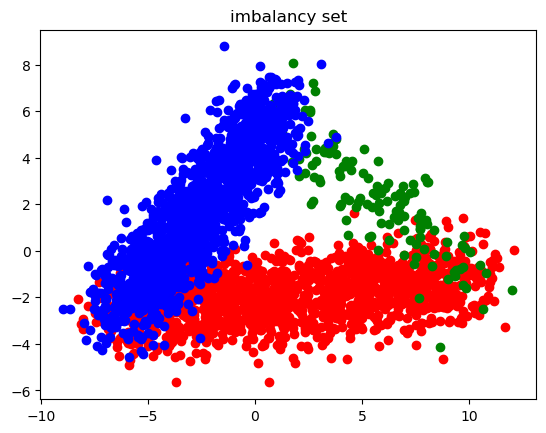

In [188]:
pca = PCA(n_components=2)
X_new_vis = pca.fit_transform(X_new)

graphic(X_new_vis, y_new, 'imbalancy set')

1 - analyze the impact on the accuracy on the 1000 test waves

In [189]:
def plot_accuracy(k_max, X_train, X_test, y_train, y_test):
    fig = plt.figure()
    accuracy = []

    acc_max = 0
    k_best = 0

    for k in range(1,k_max):
      #Define the number of neighbor of k which will be used for the classifier
      knn = neighbors.KNeighborsClassifier(k)
      knn.fit(X_train, y_train)
      #Train the classifier and measure the accuracy
      y_pred = knn.predict(X_test)
    
      acc = accuracy_score(y_test, y_pred)
      accuracy.append(acc)

      if acc > acc_max :
        acc_max = acc
        k_best = k

    plt.title("Model test for k ranging from 1 to k_max \n Measures test accuracy and displays performance as a function of k.")
    plt.xlabel('k')
    plt.ylabel('accuracy')

    plt.plot(range(1,k_max), accuracy, 'o-')

    plt.show()
    
    return k_best, acc_max

Let's see how accuracy behaves when our training data is unbalanced

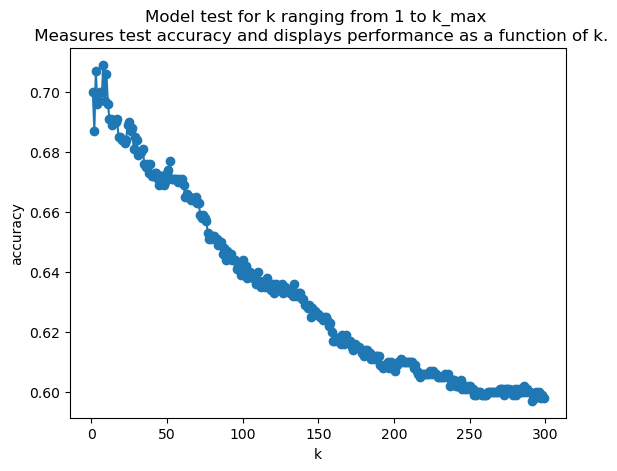

the k value with the best accuracy is 8 , its accuracy is 0.709


In [190]:
k_best_acc, acc_max = plot_accuracy(300, X_new, X_test, y_new, y_test)

print("the k value with the best accuracy is", k_best_acc,", its accuracy is", acc_max) 

Let's see how the accuracy behaves when our training data is balanced enough, this is our baseline data

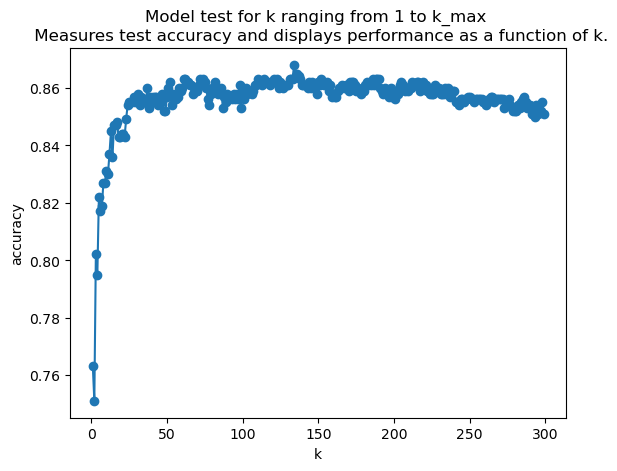

the k value with the best accuracy is 134 , its accuracy is 0.868


In [182]:
k_best_acc, acc_max = plot_accuracy(300, X_train, X_test, y_train, y_test)

print("the k value with the best accuracy is", k_best_acc,", its accuracy is", acc_max) 

2 - Tune k w.r.t. the F-measure and compare the performance with the accuracy

In [191]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

def plot_Fmeasure(k_max, X_train, X_test, y_train, y_test):
    
    fmeasure = []
    laccuracy = []
    
    f1_max = 0
    k_best = 0

    for k in range(1,k_max):

      knn = KNeighborsClassifier(k)
      knn.fit(X_train, y_train)

      y_pred = knn.predict(X_test)
    
      f1 = f1_score(y_test.tolist(), y_pred, average='weighted')
      accuracy = accuracy_score(y_test.tolist(), y_pred) 
    
      fmeasure.append(f1)
      laccuracy.append(accuracy)
      
      if f1 > f1_max :
        f1_max = f1
        k_best = k
    
    fig = plt.figure()
    plt.title("Model test for k ranging from 1 to k_max \n Measures test f measure and displays performance as a function of k.")
    plt.xlabel('k')
    plt.ylabel('F - measure')

    plt.plot(range(1,k_max), fmeasure, color='green', label="F-measure")
    plt.plot(range(1,k_max), laccuracy, color='blue', label="Accuracy")
    
    plt.legend()
    plt.show()
    
    return k_best, f1_max

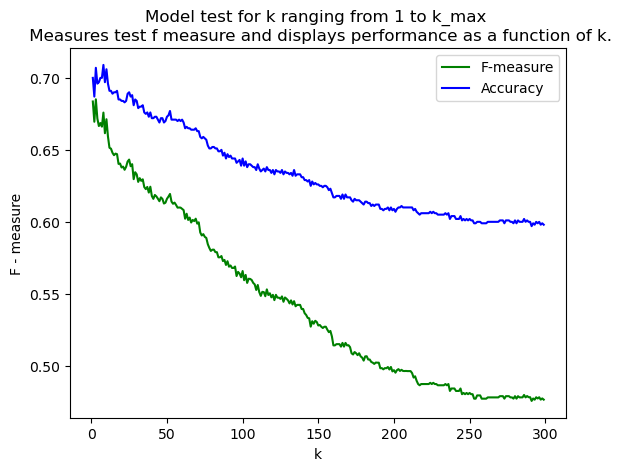

the k value with the best f-measure is 3 , its f-measure is 0.6851209490631304


In [192]:
k_best, f1 = plot_Fmeasure(300, X_new, X_test, y_new, y_test)

print("the k value with the best f-measure is", k_best,", its f-measure is", f1)